In [ ]:
"""
Author: Ze Hong Wu
Purpose: Part of the CSCI 49377 project's Stage 5 training process.
This notebook will subject a DenseNet-based model through a number of changes.
"""

"\nAuthor: Ze Hong Wu\nPurpose: Part of the CSCI 49377 project's Stage 5 training process.\nThis notebook will subject a DenseNet-based model through a number of changes.\n"

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from glob import glob
import random

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Input, MaxPool2D, Dense, Dropout, Flatten, Reshape, GlobalAveragePooling2D, CenterCrop
from tensorflow.keras.backend import clear_session
from tensorflow.keras.metrics import F1Score
from tensorflow.keras.saving import load_model
from tensorflow.keras.optimizers.legacy import Adam
# https://stackoverflow.com/questions/71153492/invalid-argument-error-graph-execution-error
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import BatchNormalization, ReLU, LeakyReLU, Add, Activation, SeparableConv2D, Concatenate, AveragePooling2D
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! ls /content/drive/MyDrive/49377_tfrecords

densenet  resnet34  stage4  stage5  test.tfrecord  train.tfrecord  val.tfrecord  vgg16	xception


In [ ]:
TFR_PATH = "/content/drive/MyDrive/49377_tfrecords/"
# Using an absolute path based on this one rumor I heard

## DO NOT MOVE THIS CELL ANY LOWER; parse function needs labels
image_shape = (512, 512, 3)
labels = ['dog', 'tiger', 'house', 'bell', 'horse']

In [ ]:
def _parse_function(example):
    # Define your tfrecord again. The contents should be adjusted according to how you wrote your tfrecord file.
    keys_to_features = {
        'image': tf.io.FixedLenFeature([], tf.string),  # Image as a raw byte string
        'label': tf.io.FixedLenFeature([], tf.int64),     # Label as an integer
    }

    # Parse the input `tf.train.Example` using the feature description dictionary above
    parsed_features = tf.io.parse_single_example(example, keys_to_features)

    # Decode the image data into an array
    image = tf.image.decode_png(parsed_features['image'], channels=3)
    image = tf.image.resize(image, [512, 512])
    image = tf.cast(image, tf.float32) / 255.0

    # We will use one-hot enocded labels
    label = parsed_features['label']
    label = tf.one_hot(label, depth=len(labels), dtype=tf.int64)

    return image, label

def load_tfrecord_dataset(tfrecord_file, batch_size=32):
    # Load the dataset
    dataset = tf.data.TFRecordDataset(tfrecord_file, num_parallel_reads=tf.data.AUTOTUNE)


    # Parse the serialized data in the TFRecords
    dataset = dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(3 * batch_size)

    # Set the batch size
    dataset = dataset.batch(batch_size, drop_remainder=True)

    # Prefetch will enable the input pipeline to asynchronously fetch batches while the model is training
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

In [ ]:
#Paths to the TFRecord files

train_file = TFR_PATH + 'train.tfrecord'
val_file = TFR_PATH + 'val.tfrecord'
# I initially had the valid tfrecord named "valid.tfrecord"
# but model.fit() below insisted on looking for "val.tfrecord" during validation session
# (despite me manually passing it X_val for validation),
# which led to a Graph Execution Error and many open tabs trying to fix this bug.
# I don't know why this is the case and it's too late at night for me to be figuring that out.
test_file = TFR_PATH + 'test.tfrecord'

# Loading the datasets
X_train = load_tfrecord_dataset(train_file)
X_val = load_tfrecord_dataset(val_file)
X_test = load_tfrecord_dataset(test_file)

In [ ]:
# https://stackoverflow.com/questions/67878735/how-to-change-the-dtype-of-data-in-tf-data-dataset
# The labels are in int64 format but the model outputs are in float32
# Macro F1Score doesn't work when that is the case
# I am casting the labels to float32
X_train = X_train.map(lambda x, y: (x, tf.cast(y, tf.float32)))
X_val = X_val.map(lambda x, y: (x, tf.cast(y, tf.float32)))
X_test = X_test.map(lambda x, y: (x, tf.cast(y, tf.float32)))

In [ ]:
type(X_test)

tensorflow.python.data.ops.map_op._MapDataset

<class 'tensorflow.python.framework.ops.EagerTensor'>


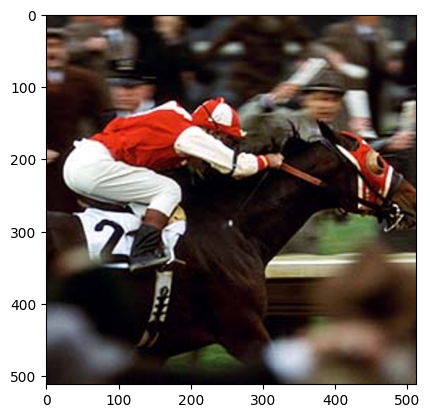

tf.Tensor([0. 0. 0. 0. 1.], shape=(5,), dtype=float32)


In [ ]:
dataset_batch = X_test.take(1)

# Take the first batch from the dataset
# Remember to usr take(1) and not take(0)
# label values are: ['dog', 'tiger', 'house', 'bell', 'horse']
for batch, label in dataset_batch.take(1):
    # Extract the first image from the batch
    # print("is loop running?")
    image = batch[0]  # This gets the first image in the batch
    print(type(image))

    # The image tensor shape is (512, 512, 3), you can now visualize it
    plt.imshow(image)
    plt.show()
    print(label[0])

In [ ]:
from tensorflow import random

In [ ]:
def make_densenet(filters=32, compression_factor=0.5, repetitions=[3,6,12,8], activation="relu", keep_last_transition=False,
                  optimizer=SGD(momentum=0.9, weight_decay = 0.00001, learning_rate=0.1,)):
  """
  This function generates, compiles, and returns a DenseNet CNN model using the given hyperparameters.
  """
  clear_session()
  np.random.seed(42)
  random.set_seed(42)
  # This is a shrunk down version of the DenseNet-121 architecture.
  # The number of Conv blocks have been halved across the board.
  # Without this change, the Colab instance would consume all RAM and crash when training.
  # filters=32
  # compression_factor=0.5
  input = Input(shape=image_shape)
  x = Conv2D(filters=64, kernel_size=7, strides=2, padding="same", activation=activation)(input)
  x = MaxPool2D(pool_size=(3,3), strides=2, padding="same")(x)

  # Conv blocks
  # repetitions = [3,6,12,8]

  for repetition in repetitions:
    for i in range(repetition):
      y = BatchNormalization()(x)
      y = ReLU()(y)
      y = Conv2D(filters=filters*4, kernel_size=1, strides=1, padding = 'same')(y)
      y = BatchNormalization()(y)
      y = ReLU()(y)
      y = Conv2D(filters=filters, kernel_size=3, strides=1, padding = 'same')(y)
      x = Concatenate()([y,x])
    if repetition != repetitions[len(repetitions)-1] or keep_last_transition: # last conv block doesn't get a transition layer, unless specified otherwise
      x = BatchNormalization()(x)
      x = ReLU()(x) # old bug here caused the layer to be named xx instead of x causing one case of skipped relu
      x = Conv2D(filters=int(x.shape[-1]*compression_factor), kernel_size=1, strides=1, padding = 'same')(x)
      x = AveragePooling2D(pool_size=(2,2), strides=2, padding="same")(x)

  x = GlobalAveragePooling2D()(x)
  output = Dense(5, activation="softmax")(x)

  #optim = SGD(momentum=0.9, weight_decay = 0.00001, learning_rate=0.1, clipnorm=1.0)

  my_densenet = Model(inputs=input, outputs=output)
  my_densenet.compile(optimizer=optimizer,
                      # learning rate as chosen by authors for ImageNet
                      metrics=["accuracy", F1Score(average="macro")], loss="categorical_crossentropy")
  return my_densenet

In [ ]:
num_epochs = 24 # arbitrarily decided epoch count
batch_size = 32
train_samples_count = 18000
steps_per_epoch = train_samples_count // batch_size

## Summary Statistics

Part 1: attempts to reconcile my work with Stage 4 work

Model | Prev model(s) | Changes | Loss | Accuracy | F1
-- | -- | -- | -- | -- | --
adam-densenet | none | Results from Stage 4 | 0.3813 | 0.8574 | 0.8589
compression-densenet | none | Work from Stage 4 | 0.4658 | 0.8433 | 0.8422
combined-densenet | adam + compression | Combining the above two | 0.5318 | 0.8143 | 0.8164
nocompress-densenet | combined-densenet | removed compression=0.66 | 0.5311 | 0.8147 | 0.8168
last-trans-densenet | nocompress-densenet | added transition layer from adam densenet | 0.5304 | 0.8121 | 0.8117

Part 2: fixed work

Turns out, both the adam-densenet and the compressed-densenet had strange events going on in it. Adam-densenet had the learning rate optimizer override its initial lr while compression-densenet missed a ReLU() during the transition layer. I "fixed" these changes for combined-densenet2. Yet, despite this, I am unable to replicate the successes I had with either compression-densenet or adam-densenet.

Model | Prev model(s) | Changes | Loss | Accuracy | F1
-- | -- | -- | -- | -- | --
adam-densenet | none | Results from Stage 4 | 0.3813 | 0.8574 | 0.8589
compression-densenet | none | Work from Stage 4 | 0.4658 | 0.8433 | 0.8422
combined-densenet2 | adam + compression | Bugfix and combination | 0.5510 | 0.8125 | 0.8128
learning-densenet1 | combined-densenet2 | Using first lr scheduler | 0.4581 | 0.8464 | 0.8450
learning-densenet2 | combined-densenet2 | Using second lr scheduler | 0.5171 | 0.8304 | 0.8275
learning-densenet3 | combined-densenet2 | Using third lr scheduler | 0.5068 | 0.8384 | 0.8365
learning-densenet4 | combined-densenet2 | Using fourth lr scheduler | 0.6234 | 0.7937 | 0.7933

Part 3: fixed work, part 2; removed compression=0.66 and achieved better results.

Model | Prev model(s) | Changes | Loss | Accuracy | F1
-- | -- | -- | -- | -- | --
learning-densenet1 | combined-densenet2 | Using first lr scheduler | 0.4581 | 0.8464 | 0.8450
final-densenet | learning-densenet1 | removed compression | 0.4495 | 0.8455 | 0.8438
final-densenet2 | learning-densenet4 | removed compression | 0.5124 | 0.8192 | 0.8179
final-densenet3 | learning-densenet4 | tweaked the lr scheduler | 0.4880 | 0.8326 | 0.8316

loss: 0.4880 - accuracy: 0.8326 - f1_score: 0.8316

In [ ]:
from tensorflow import random
np.random.seed(42)
random.set_seed(42)

## combined-densenet

This model combines the compression_densenet work and the Adam optimizer model work. It will serve as a baseline for final changes.

In [ ]:
clipnorm_optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
combined_densenet = make_densenet(optimizer=clipnorm_optimizer, compression_factor=0.66)
combined_densenet._name = "DenseNet_with_compression_and_Adam"
combined_densenet.summary()

Model: "DenseNet_with_compression_and_Adam"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256    

In [ ]:
#from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
current_densenet_filename = "stage5/combined_densenet_best_model_val_loss.keras"
checkpoint = ModelCheckpoint(
    TFR_PATH+current_densenet_filename,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch',
    initial_value_threshold=None
)
early_stop = EarlyStopping(monitor='val_loss', mode='min',
                           verbose=1, patience=4,
                           min_delta=0, restore_best_weights=True)
def schedule_func(epoch, lr):
  # Authors reduced lr by 90% at 50% and 75% mark of total training epochs
  # if epoch == 1: return 0.1
  if epoch == num_epochs//2 or epoch == int(num_epochs*0.75): return lr * 0.1
  else: return lr
lr_scheduler = LearningRateScheduler(schedule_func)

In [ ]:
# eliminating early stopping for now
history = combined_densenet.fit(X_train, epochs=num_epochs, validation_data=X_val, callbacks=[checkpoint])

Epoch 1/24
    562/Unknown - 280s 450ms/step - loss: 1.2965 - accuracy: 0.4970 - f1_score: 0.4948
Epoch 1: val_loss improved from inf to 4.71848, saving model to /content/drive/MyDrive/49377_tfrecords/stage5/combined_densenet_best_model_val_loss.keras
562/562 [==============================] - 324s 528ms/step - loss: 1.2965 - accuracy: 0.4970 - f1_score: 0.4948 - val_loss: 4.7185 - val_accuracy: 0.2438 - val_f1_score: 0.1433
Epoch 2/24
562/562 [==============================] - ETA: 0s - loss: 0.9549 - accuracy: 0.6321 - f1_score: 0.6320
Epoch 2: val_loss improved from 4.71848 to 1.43215, saving model to /content/drive/MyDrive/49377_tfrecords/stage5/combined_densenet_best_model_val_loss.keras
562/562 [==============================] - 256s 452ms/step - loss: 0.9549 - accuracy: 0.6321 - f1_score: 0.6320 - val_loss: 1.4321 - val_accuracy: 0.5246 - val_f1_score: 0.4983
Epoch 3/24
562/562 [==============================] - ETA: 0s - loss: 0.8376 - accuracy: 0.6783 - f1_score: 0.6791
Epoch 

In [ ]:
# example evaluating with tf.data.Dataset
# load best model from drive before evaluating
#best_model_path = "stage5/combined_densenet_best_model_val_loss.keras"
#densenet = load_model(TFR_PATH+best_model_path)
scores = combined_densenet.evaluate(X_test,
                              #steps=32
                              )

70/70 [==============================] - 26s 360ms/step - loss: 0.8115 - accuracy: 0.7746 - f1_score: 0.7712


In [ ]:
# example evaluating with tf.data.Dataset
# load best model from drive before evaluating
best_model_path = "stage5/combined_densenet_best_model_val_loss.keras"
densenet = load_model(TFR_PATH+best_model_path)
scores = densenet.evaluate(X_test,
                              #steps=32
                              )

70/70 [==============================] - 17s 159ms/step - loss: 0.5312 - accuracy: 0.8143 - f1_score: 0.8163


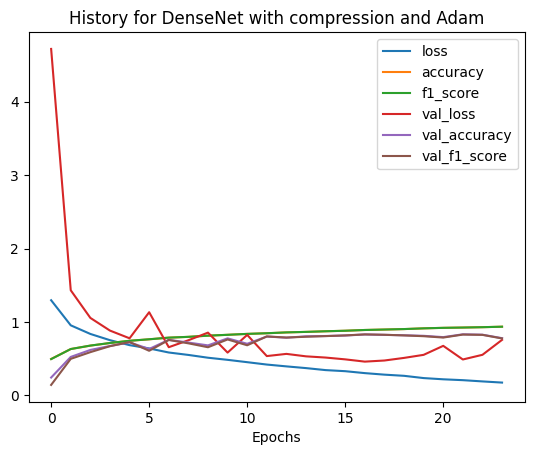

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# Draw the losses over time using plt
losses = pd.DataFrame(history.history).plot();
plt.title("History for DenseNet with compression and Adam")
plt.xlabel("Epochs")
plt.savefig(TFR_PATH+"stage5/combined_densenet_losses_over_time.png")
plt.show()

## combined-densenet-v2

A second try at remaking combined_densenet, now with an unnoticed and vital bug in the architecture resolved.

In [ ]:
adam_optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
combined_densenet2 = make_densenet(optimizer=adam_optimizer, compression_factor=0.66)
combined_densenet2._name = "DenseNet_with_compression_and_Adam_v2"
combined_densenet2.summary()

Model: "DenseNet_with_compression_and_Adam_v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256 

In [ ]:
#from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
current_densenet_filename = "stage5/combined_densenet_v2_best_model_val_loss.keras"
checkpoint = ModelCheckpoint(
    TFR_PATH+current_densenet_filename,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch',
    initial_value_threshold=None
)
early_stop = EarlyStopping(monitor='val_loss', mode='min',
                           verbose=1, patience=4,
                           min_delta=0, restore_best_weights=True)
def schedule_func(epoch, lr):
  # Authors reduced lr by 90% at 50% and 75% mark of total training epochs
  # if epoch == 1: return 0.1
  if epoch == num_epochs//2 or epoch == int(num_epochs*0.75): return lr * 0.1
  else: return lr
lr_scheduler = LearningRateScheduler(schedule_func)

In [ ]:
# eliminating early stopping for now
history = combined_densenet2.fit(X_train, epochs=num_epochs, validation_data=X_val, callbacks=[checkpoint])

Epoch 1/24
    562/Unknown - 110s 153ms/step - loss: 1.3318 - accuracy: 0.4685 - f1_score: 0.4654
Epoch 1: val_loss improved from inf to 1.37508, saving model to /content/drive/MyDrive/49377_tfrecords/stage5/combined_densenet_v2_best_model_val_loss.keras
562/562 [==============================] - 122s 174ms/step - loss: 1.3318 - accuracy: 0.4685 - f1_score: 0.4654 - val_loss: 1.3751 - val_accuracy: 0.4911 - val_f1_score: 0.4940
Epoch 2/24
562/562 [==============================] - ETA: 0s - loss: 0.9628 - accuracy: 0.6278 - f1_score: 0.6276
Epoch 2: val_loss improved from 1.37508 to 0.99271, saving model to /content/drive/MyDrive/49377_tfrecords/stage5/combined_densenet_v2_best_model_val_loss.keras
562/562 [==============================] - 92s 163ms/step - loss: 0.9628 - accuracy: 0.6278 - f1_score: 0.6276 - val_loss: 0.9927 - val_accuracy: 0.6317 - val_f1_score: 0.6041
Epoch 3/24
562/562 [==============================] - ETA: 0s - loss: 0.8618 - accuracy: 0.6694 - f1_score: 0.6690
E

In [ ]:
# example evaluating with tf.data.Dataset
# load best model from drive before evaluating
best_model_path = "stage5/combined_densenet_v2_best_model_val_loss.keras"
densenet = load_model(TFR_PATH+best_model_path)
scores = densenet.evaluate(X_test,
                              #steps=32
                              )

70/70 [==============================] - 11s 123ms/step - loss: 0.5510 - accuracy: 0.8125 - f1_score: 0.8128


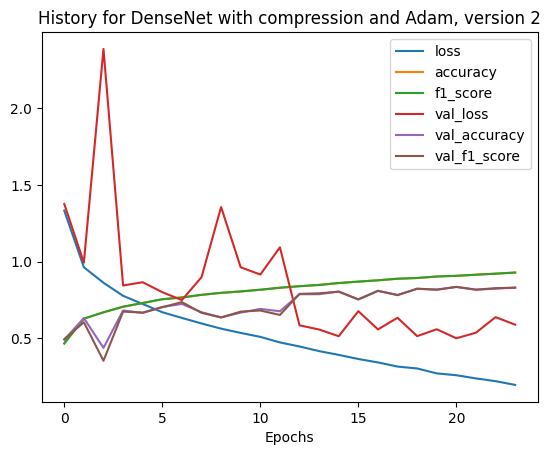

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# Draw the losses over time using plt
losses = pd.DataFrame(history.history).plot();
plt.title("History for DenseNet with compression and Adam, version 2")
plt.xlabel("Epochs")
plt.savefig(TFR_PATH+"stage5/combined_densenet_v2_losses_over_time.png")
plt.show()

## learning-densenet-v1

First DenseNet with learning rate scheduler (-90% lr at 50% and 75% of total epoch count)

In [ ]:
adam_optimizer = Adam(learning_rate=0.01, clipnorm=1.0)
learning_densenet1 = make_densenet(optimizer=adam_optimizer, compression_factor=0.66)
learning_densenet1._name = "DenseNet_with_learning_scheduler_1"
learning_densenet1.summary()

Model: "DenseNet_with_learning_scheduler_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256    

In [ ]:
#from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
current_densenet_filename = "stage5/learning_densenet_1_best_model_val_loss.keras"
checkpoint = ModelCheckpoint(
    TFR_PATH+current_densenet_filename,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch',
    initial_value_threshold=None
)
early_stop = EarlyStopping(monitor='val_loss', mode='min',
                           verbose=1, patience=4,
                           min_delta=0, restore_best_weights=True)
def schedule_func(epoch, lr):
  # Authors reduced lr by 90% at 50% and 75% mark of total training epochs
  # if epoch == 1: return 0.1
  if epoch == num_epochs//2 or epoch == int(num_epochs*0.75): return lr * 0.1
  else: return lr
lr_scheduler = LearningRateScheduler(schedule_func)

In [ ]:
# eliminating early stopping for now
history = learning_densenet1.fit(X_train, epochs=num_epochs, validation_data=X_val, callbacks=[checkpoint, lr_scheduler])

Epoch 1/24
    562/Unknown - 100s 154ms/step - loss: 1.9281 - accuracy: 0.3163 - f1_score: 0.3097
Epoch 1: val_loss improved from inf to 1.43134, saving model to /content/drive/MyDrive/49377_tfrecords/stage5/learning_densenet_1_best_model_val_loss.keras
562/562 [==============================] - 108s 167ms/step - loss: 1.9281 - accuracy: 0.3163 - f1_score: 0.3097 - val_loss: 1.4313 - val_accuracy: 0.4071 - val_f1_score: 0.3857 - lr: 0.0100
Epoch 2/24
562/562 [==============================] - ETA: 0s - loss: 1.3411 - accuracy: 0.4422 - f1_score: 0.4322
Epoch 2: val_loss did not improve from 1.43134
562/562 [==============================] - 92s 163ms/step - loss: 1.3411 - accuracy: 0.4422 - f1_score: 0.4322 - val_loss: 2.1908 - val_accuracy: 0.3094 - val_f1_score: 0.2238 - lr: 0.0100
Epoch 3/24
562/562 [==============================] - ETA: 0s - loss: 1.2383 - accuracy: 0.4950 - f1_score: 0.4895
Epoch 3: val_loss did not improve from 1.43134
562/562 [==============================] - 

In [ ]:
# example evaluating with tf.data.Dataset
# load best model from drive before evaluating
# best_model_path = "stage5/combined_densenet_best_model_val_loss.keras"
# densenet = load_model(TFR_PATH+best_model_path)
scores = learning_densenet1.evaluate(X_test,
                              #steps=32
                              )

70/70 [==============================] - 5s 68ms/step - loss: 0.4669 - accuracy: 0.8433 - f1_score: 0.8416


In [ ]:
# example evaluating with tf.data.Dataset
# load best model from drive before evaluating
best_model_path = "stage5/learning_densenet_1_best_model_val_loss.keras"
densenet = load_model(TFR_PATH+best_model_path)
scores = densenet.evaluate(X_test,
                              #steps=32
                              )

70/70 [==============================] - 7s 70ms/step - loss: 0.4581 - accuracy: 0.8464 - f1_score: 0.8450


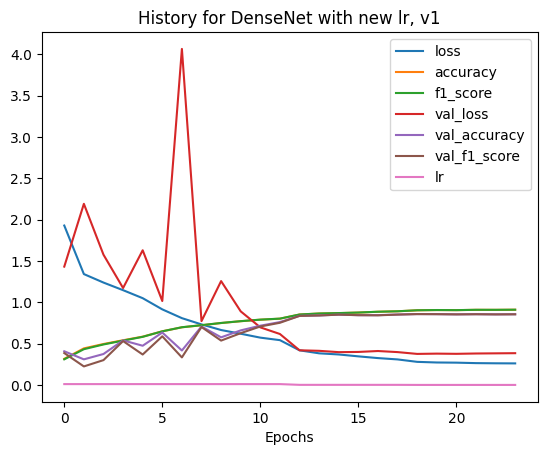

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# Draw the losses over time using plt
losses = pd.DataFrame(history.history).plot();
plt.title("History for DenseNet with new lr, v1")
plt.xlabel("Epochs")
plt.savefig(TFR_PATH+"stage5/learning_densenet_1_losses_over_time.png")
plt.show()

## learning-densenet-v2

Densenet with the second learning schedule: initial lr of 0.002 and a reduction of 50% at halfway and the three-quarters way.

In [ ]:
adam_optimizer = Adam(learning_rate=0.002, clipnorm=1.0)
learning_densenet2 = make_densenet(optimizer=adam_optimizer, compression_factor=0.66)
learning_densenet2._name = "DenseNet_with_learning_scheduler_2"
learning_densenet2.summary()

Model: "DenseNet_with_learning_scheduler_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256    

In [ ]:
#from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
current_densenet_filename = "stage5/learning_densenet_2_best_model_val_loss.keras"
checkpoint = ModelCheckpoint(
    TFR_PATH+current_densenet_filename,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch',
    initial_value_threshold=None
)
early_stop = EarlyStopping(monitor='val_loss', mode='min',
                           verbose=1, patience=4,
                           min_delta=0, restore_best_weights=True)
def schedule_func(epoch, lr):
  # Authors reduced lr by 90% at 50% and 75% mark of total training epochs
  # if epoch == 1: return 0.1
  if epoch == num_epochs//2 or epoch == int(num_epochs*0.75): return lr * 0.5
  else: return lr
lr_scheduler = LearningRateScheduler(schedule_func)

In [ ]:
# eliminating early stopping for now
history = learning_densenet2.fit(X_train, epochs=num_epochs, validation_data=X_val, callbacks=[checkpoint, lr_scheduler])

Epoch 1/24
    562/Unknown - 100s 154ms/step - loss: 1.4442 - accuracy: 0.4217 - f1_score: 0.4151
Epoch 1: val_loss improved from inf to 4.11883, saving model to /content/drive/MyDrive/49377_tfrecords/stage5/learning_densenet_2_best_model_val_loss.keras
562/562 [==============================] - 108s 168ms/step - loss: 1.4442 - accuracy: 0.4217 - f1_score: 0.4151 - val_loss: 4.1188 - val_accuracy: 0.2759 - val_f1_score: 0.1794 - lr: 0.0020
Epoch 2/24
562/562 [==============================] - ETA: 0s - loss: 1.0366 - accuracy: 0.5930 - f1_score: 0.5925
Epoch 2: val_loss improved from 4.11883 to 2.69288, saving model to /content/drive/MyDrive/49377_tfrecords/stage5/learning_densenet_2_best_model_val_loss.keras
562/562 [==============================] - 93s 164ms/step - loss: 1.0366 - accuracy: 0.5930 - f1_score: 0.5925 - val_loss: 2.6929 - val_accuracy: 0.3438 - val_f1_score: 0.2883 - lr: 0.0020
Epoch 3/24
562/562 [==============================] - ETA: 0s - loss: 0.8951 - accuracy: 0.6

In [ ]:
# example evaluating with tf.data.Dataset
# load best model from drive before evaluating
# best_model_path = "stage5/combined_densenet_best_model_val_loss.keras"
# densenet = load_model(TFR_PATH+best_model_path)
scores = learning_densenet2.evaluate(X_test,
                              #steps=32
                              )

70/70 [==============================] - 5s 70ms/step - loss: 0.7127 - accuracy: 0.8125 - f1_score: 0.8106


In [ ]:
# example evaluating with tf.data.Dataset
# load best model from drive before evaluating
best_model_path = "stage5/learning_densenet_2_best_model_val_loss.keras"
densenet = load_model(TFR_PATH+best_model_path)
scores = densenet.evaluate(X_test,
                              #steps=32
                              )

70/70 [==============================] - 7s 72ms/step - loss: 0.5171 - accuracy: 0.8304 - f1_score: 0.8275


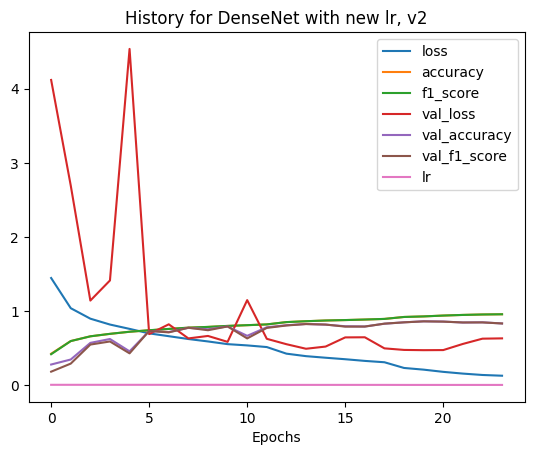

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# Draw the losses over time using plt
losses = pd.DataFrame(history.history).plot();
plt.title("History for DenseNet with new lr, v2")
plt.xlabel("Epochs")
plt.savefig(TFR_PATH+"stage5/learning_densenet_2_losses_over_time.png")
plt.show()

## learning-densenet-v3

Uses the third learning rate system: initial lr of 0.002, with a -0.0005 reduction at 25%, 50%, and 75% epoch progress.

In [ ]:
adam_optimizer = Adam(learning_rate=0.002, clipnorm=1.0)
learning_densenet3 = make_densenet(optimizer=adam_optimizer, compression_factor=0.66)
learning_densenet3._name = "DenseNet_with_learning_scheduler_3"
learning_densenet3.summary()

Model: "DenseNet_with_learning_scheduler_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256    

In [ ]:
#from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
current_densenet_filename = "stage5/learning_densenet_3_best_model_val_loss.keras"
checkpoint = ModelCheckpoint(
    TFR_PATH+current_densenet_filename,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch',
    initial_value_threshold=None
)
early_stop = EarlyStopping(monitor='val_loss', mode='min',
                           verbose=1, patience=4,
                           min_delta=0, restore_best_weights=True)
def schedule_func(epoch, lr):
  if epoch == num_epochs//2 or epoch == int(num_epochs*0.75) or epoch == int(num_epochs*0.25): return lr - 0.0005
  else: return lr
lr_scheduler = LearningRateScheduler(schedule_func)

In [ ]:
# eliminating early stopping for now
history = learning_densenet3.fit(X_train, epochs=num_epochs, validation_data=X_val, callbacks=[checkpoint, lr_scheduler])

Epoch 1/24
    562/Unknown - 101s 154ms/step - loss: 1.4794 - accuracy: 0.4094 - f1_score: 0.4030
Epoch 1: val_loss improved from inf to 2.54819, saving model to /content/drive/MyDrive/49377_tfrecords/stage5/learning_densenet_3_best_model_val_loss.keras
562/562 [==============================] - 108s 167ms/step - loss: 1.4794 - accuracy: 0.4094 - f1_score: 0.4030 - val_loss: 2.5482 - val_accuracy: 0.3406 - val_f1_score: 0.2281 - lr: 0.0020
Epoch 2/24
562/562 [==============================] - ETA: 0s - loss: 1.0495 - accuracy: 0.5846 - f1_score: 0.5833
Epoch 2: val_loss improved from 2.54819 to 1.74861, saving model to /content/drive/MyDrive/49377_tfrecords/stage5/learning_densenet_3_best_model_val_loss.keras
562/562 [==============================] - 93s 164ms/step - loss: 1.0495 - accuracy: 0.5846 - f1_score: 0.5833 - val_loss: 1.7486 - val_accuracy: 0.4955 - val_f1_score: 0.4226 - lr: 0.0020
Epoch 3/24
562/562 [==============================] - ETA: 0s - loss: 0.9223 - accuracy: 0.6

In [ ]:
# example evaluating with tf.data.Dataset
# load best model from drive before evaluating
# best_model_path = "stage5/combined_densenet_best_model_val_loss.keras"
# densenet = load_model(TFR_PATH+best_model_path)
scores = learning_densenet3.evaluate(X_test,
                              #steps=32
                              )

70/70 [==============================] - 5s 69ms/step - loss: 0.6858 - accuracy: 0.8183 - f1_score: 0.8158


In [ ]:
# example evaluating with tf.data.Dataset
# load best model from drive before evaluating
best_model_path = "stage5/learning_densenet_3_best_model_val_loss.keras"
densenet = load_model(TFR_PATH+best_model_path)
scores = densenet.evaluate(X_test,
                              #steps=32
                              )

70/70 [==============================] - 7s 70ms/step - loss: 0.5068 - accuracy: 0.8384 - f1_score: 0.8365


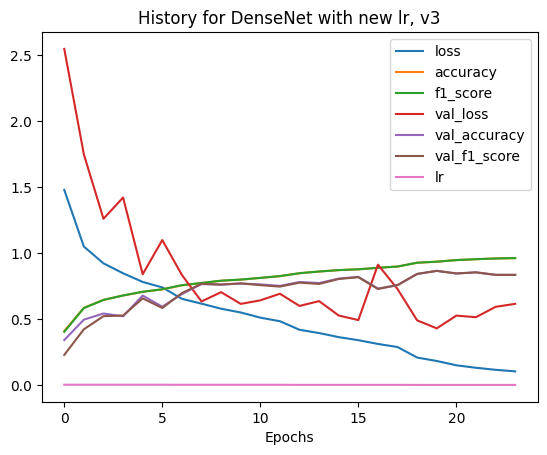

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# Draw the losses over time using plt
losses = pd.DataFrame(history.history).plot();
plt.title("History for DenseNet with new lr, v3")
plt.xlabel("Epochs")
plt.savefig(TFR_PATH+"stage5/learning_densenet_3_losses_over_time.png")
plt.show()

## learning-densenet-v4

Experimental fourth learning rate controls where the initial lr is 0.025 and the final lr is 0.001; the lr is reduced by 0.001 per epoch.

In [ ]:
adam_optimizer = Adam(learning_rate=0.025, clipnorm=1.0)
learning_densenet4 = make_densenet(optimizer=adam_optimizer, compression_factor=0.66)
learning_densenet4._name = "DenseNet_with_learning_scheduler_4"
learning_densenet4.summary()

Model: "DenseNet_with_learning_scheduler_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256    

In [ ]:
#from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
current_densenet_filename = "stage5/learning_densenet_4_best_model_val_loss.keras"
checkpoint = ModelCheckpoint(
    TFR_PATH+current_densenet_filename,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch',
    initial_value_threshold=None
)
early_stop = EarlyStopping(monitor='val_loss', mode='min',
                           verbose=1, patience=4,
                           min_delta=0, restore_best_weights=True)
def schedule_func(epoch, lr):
  return (num_epochs - epoch) * 0.001
lr_scheduler = LearningRateScheduler(schedule_func)

In [ ]:
# eliminating early stopping for now
np.random.seed(42)
random.set_seed(42)
history = learning_densenet4.fit(X_train, epochs=num_epochs, validation_data=X_val, callbacks=[checkpoint, lr_scheduler])

Epoch 1/24
    562/Unknown - 100s 154ms/step - loss: 2.2542 - accuracy: 0.3205 - f1_score: 0.3116
Epoch 1: val_loss improved from inf to 1.60581, saving model to /content/drive/MyDrive/49377_tfrecords/stage5/learning_densenet_4_best_model_val_loss.keras
562/562 [==============================] - 107s 167ms/step - loss: 2.2542 - accuracy: 0.3205 - f1_score: 0.3116 - val_loss: 1.6058 - val_accuracy: 0.3107 - val_f1_score: 0.2175 - lr: 0.0240
Epoch 2/24
562/562 [==============================] - ETA: 0s - loss: 1.3785 - accuracy: 0.4238 - f1_score: 0.4153
Epoch 2: val_loss did not improve from 1.60581
562/562 [==============================] - 92s 162ms/step - loss: 1.3785 - accuracy: 0.4238 - f1_score: 0.4153 - val_loss: 2.2403 - val_accuracy: 0.3455 - val_f1_score: 0.2721 - lr: 0.0230
Epoch 3/24
562/562 [==============================] - ETA: 0s - loss: 1.2742 - accuracy: 0.4775 - f1_score: 0.4719
Epoch 3: val_loss did not improve from 1.60581
562/562 [==============================] - 

In [ ]:
np.random.seed(42)
random.set_seed(42)
def schedule_func(epoch, lr):
  return 0.001
# since the model seems to be improving near the end, let's train a little more
lr_scheduler = LearningRateScheduler(schedule_func)
new_history = learning_densenet4.fit(X_train, epochs=8, validation_data=X_val, callbacks=[checkpoint, lr_scheduler])

Epoch 1/8
    562/Unknown - 91s 154ms/step - loss: 0.2796 - accuracy: 0.8997 - f1_score: 0.9002
Epoch 1: val_loss did not improve from 0.55763
562/562 [==============================] - 96s 165ms/step - loss: 0.2796 - accuracy: 0.8997 - f1_score: 0.9002 - val_loss: 0.5832 - val_accuracy: 0.7978 - val_f1_score: 0.7975 - lr: 0.0010
Epoch 2/8
562/562 [==============================] - ETA: 0s - loss: 0.2621 - accuracy: 0.9047 - f1_score: 0.9051
Epoch 2: val_loss did not improve from 0.55763
562/562 [==============================] - 93s 164ms/step - loss: 0.2621 - accuracy: 0.9047 - f1_score: 0.9051 - val_loss: 0.5822 - val_accuracy: 0.8040 - val_f1_score: 0.8052 - lr: 0.0010
Epoch 3/8
562/562 [==============================] - ETA: 0s - loss: 0.2492 - accuracy: 0.9106 - f1_score: 0.9110
Epoch 3: val_loss did not improve from 0.55763
562/562 [==============================] - 93s 163ms/step - loss: 0.2492 - accuracy: 0.9106 - f1_score: 0.9110 - val_loss: 0.6002 - val_accuracy: 0.8045 - va

In [ ]:
# it didn't work, oh well

In [ ]:
# example evaluating with tf.data.Dataset
# load best model from drive before evaluating
# best_model_path = "stage5/combined_densenet_best_model_val_loss.keras"
# densenet = load_model(TFR_PATH+best_model_path)
scores = learning_densenet4.evaluate(X_test,
                              #steps=32
                              )

70/70 [==============================] - 5s 69ms/step - loss: 0.6239 - accuracy: 0.7937 - f1_score: 0.7934


In [ ]:
# example evaluating with tf.data.Dataset
# load best model from drive before evaluating
best_model_path = "stage5/learning_densenet_4_best_model_val_loss.keras"
densenet = load_model(TFR_PATH+best_model_path)
scores = densenet.evaluate(X_test,
                              #steps=32
                              )

70/70 [==============================] - 7s 69ms/step - loss: 0.6234 - accuracy: 0.7937 - f1_score: 0.7933


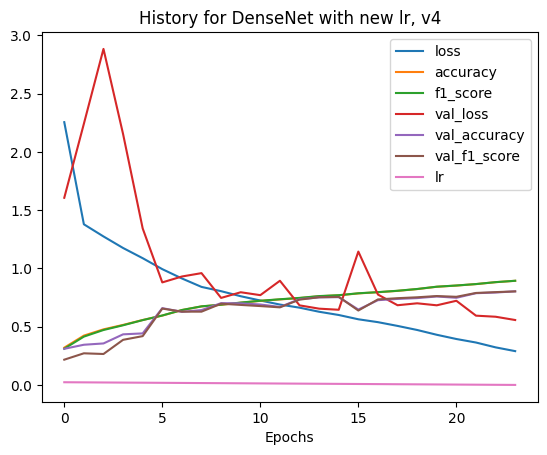

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# Draw the losses over time using plt
losses = pd.DataFrame(history.history).plot();
plt.title("History for DenseNet with new lr, v4")
plt.xlabel("Epochs")
plt.savefig(TFR_PATH+"stage5/learning_densenet_4_losses_over_time.png")
plt.show()

## learning-densenet-final

Learning Densenet v1, but with a compression of 0.5. I made this choice after re-running Ying Jie's Stage 4 model code (which differs from learning densenet v1 only by compression factor) and decided to apply the change to see if it makes a difference.

In [ ]:
adam_optimizer = Adam(learning_rate=0.01, clipnorm=1.0)
learning_densenet_fin = make_densenet(optimizer=adam_optimizer, compression_factor=0.5, keep_last_transition=True)
# reduced comp factor to match Ying Jie's work
learning_densenet_fin._name = "Learning_Densenet_Final"
learning_densenet_fin.summary()

Model: "Learning_Densenet_Final"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256       ['max_po

In [ ]:
#from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
current_densenet_filename = "stage5/learning_densenet_fin_best_model_val_loss.keras"
checkpoint = ModelCheckpoint(
    TFR_PATH+current_densenet_filename,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch',
    initial_value_threshold=None
)
early_stop = EarlyStopping(monitor='val_loss', mode='min',
                           verbose=1, patience=4,
                           min_delta=0, restore_best_weights=True)
def schedule_func(epoch, lr):
  # Authors reduced lr by 90% at 50% and 75% mark of total training epochs
  # if epoch == 1: return 0.1
  if epoch == num_epochs//2 or epoch == int(num_epochs*0.75): return lr * 0.1
  else: return lr
lr_scheduler = LearningRateScheduler(schedule_func)

In [ ]:
# eliminating early stopping for now
np.random.seed(42)
random.set_seed(42)
history = learning_densenet_fin.fit(X_train, epochs=num_epochs, validation_data=X_val, callbacks=[checkpoint, lr_scheduler])

Epoch 1/24
    562/Unknown - 244s 406ms/step - loss: 1.6137 - accuracy: 0.2909 - f1_score: 0.2755
Epoch 1: val_loss improved from inf to 8.93267, saving model to /content/drive/MyDrive/49377_tfrecords/stage5/learning_densenet_fin_best_model_val_loss.keras
562/562 [==============================] - 288s 484ms/step - loss: 1.6137 - accuracy: 0.2909 - f1_score: 0.2755 - val_loss: 8.9327 - val_accuracy: 0.1969 - val_f1_score: 0.0757 - lr: 0.0100
Epoch 2/24
562/562 [==============================] - ETA: 0s - loss: 1.3614 - accuracy: 0.4219 - f1_score: 0.4059
Epoch 2: val_loss improved from 8.93267 to 1.36266, saving model to /content/drive/MyDrive/49377_tfrecords/stage5/learning_densenet_fin_best_model_val_loss.keras
562/562 [==============================] - 253s 447ms/step - loss: 1.3614 - accuracy: 0.4219 - f1_score: 0.4059 - val_loss: 1.3627 - val_accuracy: 0.4330 - val_f1_score: 0.4049 - lr: 0.0100
Epoch 3/24
562/562 [==============================] - ETA: 0s - loss: 1.1750 - accuracy

In [ ]:
# example evaluating with tf.data.Dataset
# load best model from drive before evaluating
best_model_path = "stage5/learning_densenet_fin_best_model_val_loss.keras"
densenet = load_model(TFR_PATH+best_model_path)
scores = densenet.evaluate(X_test,
                              #steps=32
                              )

70/70 [==============================] - 29s 362ms/step - loss: 0.4495 - accuracy: 0.8455 - f1_score: 0.8438


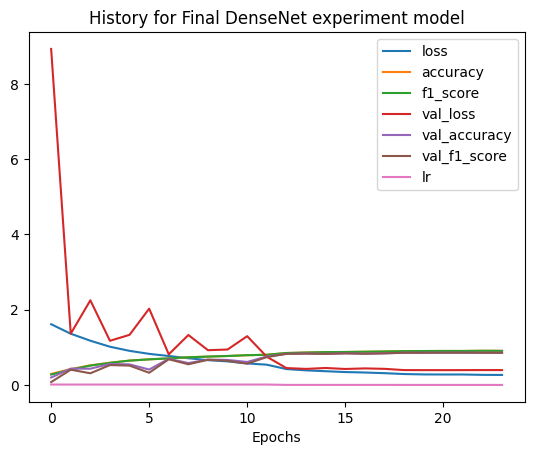

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# Draw the losses over time using plt
losses = pd.DataFrame(history.history).plot();
plt.title("History for Final DenseNet experiment model")
plt.xlabel("Epochs")
plt.savefig(TFR_PATH+"stage5/learning_densenet_fin_losses_over_time.png")
plt.show()

## learning-densenet-final2

Final-densenet but with the lr scheduler from learning-densenet4.

In [ ]:
adam_optimizer = Adam(learning_rate=0.01, clipnorm=1.0)
learning_densenet_fin2 = make_densenet(optimizer=adam_optimizer, compression_factor=0.5, keep_last_transition=True)
# reduced comp factor to match Ying Jie's work
learning_densenet_fin2._name = "Learning_Densenet_Final2"
learning_densenet_fin2.summary()

Model: "Learning_Densenet_Final2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256       ['max_p

In [ ]:
#from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
current_densenet_filename = "stage5/learning_densenet_fin2_best_model_val_loss.keras"
checkpoint = ModelCheckpoint(
    TFR_PATH+current_densenet_filename,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch',
    initial_value_threshold=None
)
early_stop = EarlyStopping(monitor='val_loss', mode='min',
                           verbose=1, patience=4,
                           min_delta=0, restore_best_weights=True)
def schedule_func3(epoch, lr):
    #print(f"epoch: {epoch}")
    if epoch <= 6:  return round((num_epochs - (epoch + 13)) * 0.001, 6)
    elif epoch <= 12: return round((num_epochs - (epoch + 10)) * 0.0006, 6)
    elif epoch <= 18: return round((num_epochs - (epoch + 0)) * 0.0001, 7)
    else: return round((num_epochs - (epoch - 0)) * 0.0001 + 0.0001, 7)
lr_scheduler3 = LearningRateScheduler(schedule_func3)

In [ ]:
for idr in range(1, 25):
  print(schedule_func3(idr, 3))

0.01
0.009
0.008
0.007
0.006
0.005
0.0042
0.0036
0.003
0.0024
0.0018
0.0012
0.0011
0.001
0.0009
0.0008
0.0007
0.0006
0.0006
0.0005
0.0004
0.0003
0.0002
0.0001


In [ ]:
# eliminating early stopping for now
history = learning_densenet_fin2.fit(X_train, epochs=num_epochs, validation_data=X_val, callbacks=[checkpoint, lr_scheduler3])

Epoch 1/24
    562/Unknown - 244s 403ms/step - loss: 1.6220 - accuracy: 0.3028 - f1_score: 0.2852
Epoch 1: val_loss improved from inf to 1.59765, saving model to /content/drive/MyDrive/49377_tfrecords/stage5/learning_densenet_fin2_best_model_val_loss.keras
562/562 [==============================] - 288s 481ms/step - loss: 1.6220 - accuracy: 0.3028 - f1_score: 0.2852 - val_loss: 1.5976 - val_accuracy: 0.3714 - val_f1_score: 0.3153 - lr: 0.0120
Epoch 2/24
562/562 [==============================] - ETA: 0s - loss: 1.3171 - accuracy: 0.4506 - f1_score: 0.4358
Epoch 2: val_loss did not improve from 1.59765
562/562 [==============================] - 255s 452ms/step - loss: 1.3171 - accuracy: 0.4506 - f1_score: 0.4358 - val_loss: 1.6539 - val_accuracy: 0.2871 - val_f1_score: 0.2366 - lr: 0.0105
Epoch 3/24
562/562 [==============================] - ETA: 0s - loss: 1.1879 - accuracy: 0.5161 - f1_score: 0.5106
Epoch 3: val_loss did not improve from 1.59765
562/562 [==============================

In [ ]:
# example evaluating with tf.data.Dataset
# load best model from drive before evaluating
best_model_path = "stage5/learning_densenet_fin2_best_model_val_loss.keras"
densenet = load_model(TFR_PATH+best_model_path)
scores = densenet.evaluate(X_test,
                              #steps=32
                              )

70/70 [==============================] - 28s 350ms/step - loss: 0.5124 - accuracy: 0.8192 - f1_score: 0.8179


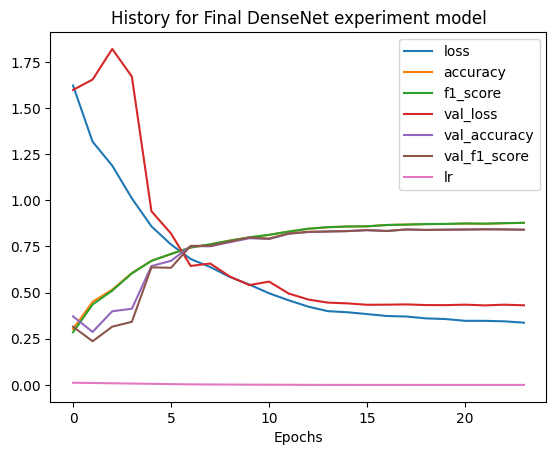

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# Draw the losses over time using plt
losses = pd.DataFrame(history.history).plot();
plt.title("History for Final DenseNet experiment model")
plt.xlabel("Epochs")
plt.savefig(TFR_PATH+"stage5/learning_densenet_fin2_losses_over_time.png")
plt.show()

## learning-densenet-final3

Yet another one.

In [ ]:
adam_optimizer = Adam(learning_rate=0.01, clipnorm=1.0)
learning_densenet_fin3 = make_densenet(optimizer=adam_optimizer, compression_factor=0.5, keep_last_transition=True)
# reduced comp factor to match Ying Jie's work
learning_densenet_fin3._name = "Learning_Densenet_Final3"
learning_densenet_fin3.summary()

Model: "Learning_Densenet_Final3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256       ['max_p

In [ ]:
#from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
current_densenet_filename = "stage5/learning_densenet_fin3_best_model_val_loss.keras"
checkpoint = ModelCheckpoint(
    TFR_PATH+current_densenet_filename,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch',
    initial_value_threshold=None
)
early_stop = EarlyStopping(monitor='val_loss', mode='min',
                           verbose=1, patience=4,
                           min_delta=0, restore_best_weights=True)
# def schedule_func3(epoch, lr):
#     #print(f"epoch: {epoch}")
#     if epoch <= 6:  return round((num_epochs - (epoch + 13)) * 0.001, 6)
#     elif epoch <= 12: return round((num_epochs - (epoch + 10)) * 0.0006, 6)
#     elif epoch <= 18: return round((num_epochs - (epoch + 0)) * 0.0001, 7)
#     else: return round((num_epochs - (epoch - 0)) * 0.0001 + 0.0001, 7)
def schedule_func4(epoch, lr):
  if epoch <= 8: return round((num_epochs - (epoch + 15)) * 0.00125, 6)
  elif epoch <= 16: return round((num_epochs - (epoch + 7)) * 0.000125, 6)
  else: return round((num_epochs - (epoch - 1)) * 0.0000125, 6)
lr_scheduler4 = LearningRateScheduler(schedule_func4)

In [ ]:
for idr in range(1, 25):
  print(idr)
  print(schedule_func4(idr, 3))

1
0.01
2
0.00875
3
0.0075
4
0.00625
5
0.005
6
0.00375
7
0.0025
8
0.00125
9
0.001
10
0.000875
11
0.00075
12
0.000625
13
0.0005
14
0.000375
15
0.00025
16
0.000125
17
0.0001
18
8.7e-05
19
7.5e-05
20
6.3e-05
21
5e-05
22
3.8e-05
23
2.5e-05
24
1.3e-05


In [ ]:
# eliminating early stopping for now
np.random.seed(42)
random.set_seed(42)
history = learning_densenet_fin3.fit(X_train, epochs=num_epochs, validation_data=X_val, callbacks=[checkpoint, lr_scheduler4])

Epoch 1/24
    562/Unknown - 244s 407ms/step - loss: 1.6081 - accuracy: 0.3080 - f1_score: 0.2912
Epoch 1: val_loss improved from inf to 4.46161, saving model to /content/drive/MyDrive/49377_tfrecords/stage5/learning_densenet_fin3_best_model_val_loss.keras
562/562 [==============================] - 288s 485ms/step - loss: 1.6081 - accuracy: 0.3080 - f1_score: 0.2912 - val_loss: 4.4616 - val_accuracy: 0.2192 - val_f1_score: 0.1206 - lr: 0.0113
Epoch 2/24
562/562 [==============================] - ETA: 0s - loss: 1.3028 - accuracy: 0.4601 - f1_score: 0.4492
Epoch 2: val_loss improved from 4.46161 to 1.32886, saving model to /content/drive/MyDrive/49377_tfrecords/stage5/learning_densenet_fin3_best_model_val_loss.keras
562/562 [==============================] - 271s 479ms/step - loss: 1.3028 - accuracy: 0.4601 - f1_score: 0.4492 - val_loss: 1.3289 - val_accuracy: 0.4558 - val_f1_score: 0.4380 - lr: 0.0100
Epoch 3/24
562/562 [==============================] - ETA: 0s - loss: 1.1452 - accura

In [ ]:
# example evaluating with tf.data.Dataset
# load best model from drive before evaluating
best_model_path = "stage5/learning_densenet_fin3_best_model_val_loss.keras"
densenet = load_model(TFR_PATH+best_model_path)
scores = densenet.evaluate(X_test,
                              #steps=32
                              )

70/70 [==============================] - 34s 423ms/step - loss: 0.4880 - accuracy: 0.8326 - f1_score: 0.8316


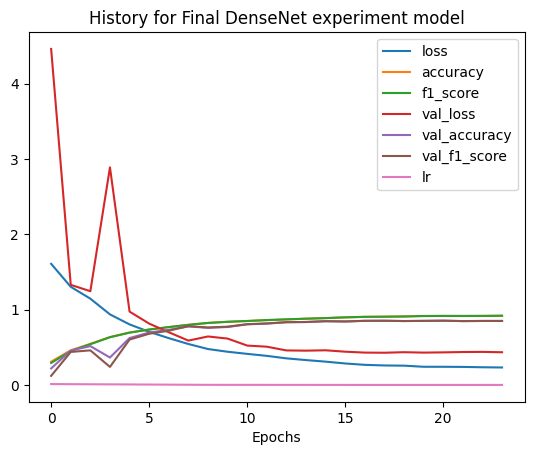

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# Draw the losses over time using plt
losses = pd.DataFrame(history.history).plot();
plt.title("History for Final DenseNet experiment model")
plt.xlabel("Epochs")
plt.savefig(TFR_PATH+"stage5/learning_densenet_fin3_losses_over_time.png")
plt.show()

## DIVIDER LINE
====================

## No compression DenseNet

The name is a misnomer. This model revers the compression factor = 0.66 change from Stage 4 in hopes of fixing an inconsistency involving the combination of Adam() and compression_densenet.

In [ ]:
# Compression had weak effects on improving the model during Stage 4, so maybe it is acting antagonistically with Adam?
clipnorm_optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
nocompress_densenet = make_densenet(optimizer=clipnorm_optimizer)
nocompress_densenet._name = "DenseNet_with_no_compression_for_adam"
nocompress_densenet.summary()

Model: "DenseNet_with_no_compression_for_adam"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256 

In [ ]:
#from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
current_densenet_filename = "stage5/nocompress_densenet_best_model_val_loss.keras"
checkpoint = ModelCheckpoint(
    TFR_PATH+current_densenet_filename,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch',
    initial_value_threshold=None
)
early_stop = EarlyStopping(monitor='val_loss', mode='min',
                           verbose=1, patience=4,
                           min_delta=0, restore_best_weights=True)
def schedule_func(epoch, lr):
  # Authors reduced lr by 90% at 50% and 75% mark of total training epochs
  # if epoch == 1: return 0.1
  if epoch == num_epochs//2 or epoch == int(num_epochs*0.75): return lr * 0.1
  else: return lr
lr_scheduler = LearningRateScheduler(schedule_func)

In [ ]:
# eliminating early stopping for now
history = nocompress_densenet.fit(X_train, epochs=num_epochs, validation_data=X_val, callbacks=[checkpoint])

Epoch 1/24
    562/Unknown - 272s 433ms/step - loss: 1.3440 - accuracy: 0.4741 - f1_score: 0.4706
Epoch 1: val_loss improved from inf to 1.79100, saving model to /content/drive/MyDrive/49377_tfrecords/stage5/nocompress_densenet_best_model_val_loss.keras
562/562 [==============================] - 302s 487ms/step - loss: 1.3440 - accuracy: 0.4741 - f1_score: 0.4706 - val_loss: 1.7910 - val_accuracy: 0.3674 - val_f1_score: 0.3017
Epoch 2/24
562/562 [==============================] - ETA: 0s - loss: 0.9431 - accuracy: 0.6337 - f1_score: 0.6332
Epoch 2: val_loss did not improve from 1.79100
562/562 [==============================] - 267s 474ms/step - loss: 0.9431 - accuracy: 0.6337 - f1_score: 0.6332 - val_loss: 6.3520 - val_accuracy: 0.2491 - val_f1_score: 0.1714
Epoch 3/24
562/562 [==============================] - ETA: 0s - loss: 0.8367 - accuracy: 0.6799 - f1_score: 0.6799
Epoch 3: val_loss did not improve from 1.79100
562/562 [==============================] - 273s 484ms/step - loss: 0

In [ ]:
# example evaluating with tf.data.Dataset

scores = nocompress_densenet.evaluate(X_test,
                              #steps=32
                              )

70/70 [==============================] - 35s 476ms/step - loss: 0.5965 - accuracy: 0.8179 - f1_score: 0.8177


In [ ]:
# example evaluating with tf.data.Dataset
# load best model from drive before evaluating
best_model_path = "stage5/combined_densenet_best_model_val_loss.keras"
densenet = load_model(TFR_PATH+best_model_path)
scores = densenet.evaluate(X_test,
                              #steps=32
                              )

70/70 [==============================] - 28s 359ms/step - loss: 0.5311 - accuracy: 0.8147 - f1_score: 0.8168


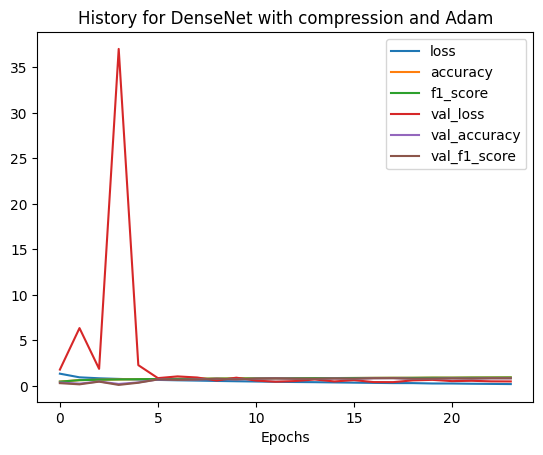

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# Draw the losses over time using plt
losses = pd.DataFrame(history.history).plot();
plt.title("History for DenseNet with compression and Adam")
plt.xlabel("Epochs")
plt.savefig(TFR_PATH+"stage5/nocompress_densenet_losses_over_time.png")
plt.show()

## last_trans_densenet

Since removing the cf didn't work, I will test to see if keeping the last transition (the adam model has an extra transition layer at the end) does anything.

In [ ]:
clipnorm_optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
last_trans_densenet = make_densenet(optimizer=clipnorm_optimizer, compression_factor=0.66, keep_last_transition=True)
last_trans_densenet._name = "DenseNet_with_last_transition_layer"
last_trans_densenet.summary()

Model: "DenseNet_with_last_transition_layer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256   

In [ ]:
#from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
current_densenet_filename = "stage5/last_trans_densenet_best_model_val_loss.keras"
checkpoint = ModelCheckpoint(
    TFR_PATH+current_densenet_filename,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch',
    initial_value_threshold=None
)
early_stop = EarlyStopping(monitor='val_loss', mode='min',
                           verbose=1, patience=4,
                           min_delta=0, restore_best_weights=True)
def schedule_func(epoch, lr):
  # Authors reduced lr by 90% at 50% and 75% mark of total training epochs
  # if epoch == 1: return 0.1
  if epoch == num_epochs//2 or epoch == int(num_epochs*0.75): return lr * 0.1
  else: return lr
lr_scheduler = LearningRateScheduler(schedule_func)

In [ ]:
# eliminating early stopping for now
history = last_trans_densenet.fit(X_train, epochs=num_epochs, validation_data=X_val, callbacks=[checkpoint])

Epoch 1/24
    562/Unknown - 285s 421ms/step - loss: 1.2710 - accuracy: 0.5031 - f1_score: 0.4982
Epoch 1: val_loss improved from inf to 5.85023, saving model to /content/drive/MyDrive/49377_tfrecords/stage5/last_trans_densenet_best_model_val_loss.keras
562/562 [==============================] - 316s 475ms/step - loss: 1.2710 - accuracy: 0.5031 - f1_score: 0.4982 - val_loss: 5.8502 - val_accuracy: 0.3281 - val_f1_score: 0.2614
Epoch 2/24
562/562 [==============================] - ETA: 0s - loss: 0.9563 - accuracy: 0.6283 - f1_score: 0.6266
Epoch 2: val_loss improved from 5.85023 to 1.75867, saving model to /content/drive/MyDrive/49377_tfrecords/stage5/last_trans_densenet_best_model_val_loss.keras
562/562 [==============================] - 273s 483ms/step - loss: 0.9563 - accuracy: 0.6283 - f1_score: 0.6266 - val_loss: 1.7587 - val_accuracy: 0.4781 - val_f1_score: 0.4168
Epoch 3/24
562/562 [==============================] - ETA: 0s - loss: 0.8425 - accuracy: 0.6796 - f1_score: 0.6797
Ep

In [ ]:
# example evaluating with tf.data.Dataset

scores = last_trans_densenet.evaluate(X_test,
                              #steps=32
                              )

70/70 [==============================] - 32s 415ms/step - loss: 0.6344 - accuracy: 0.8304 - f1_score: 0.8297


In [ ]:
# example evaluating with tf.data.Dataset
# load best model from drive before evaluating
best_model_path = "stage5/last_trans_densenet_best_model_val_loss.keras"
densenet = load_model(TFR_PATH+best_model_path)
scores = densenet.evaluate(X_test,
                              #steps=32
                              )

70/70 [==============================] - 32s 360ms/step - loss: 0.5304 - accuracy: 0.8121 - f1_score: 0.8117


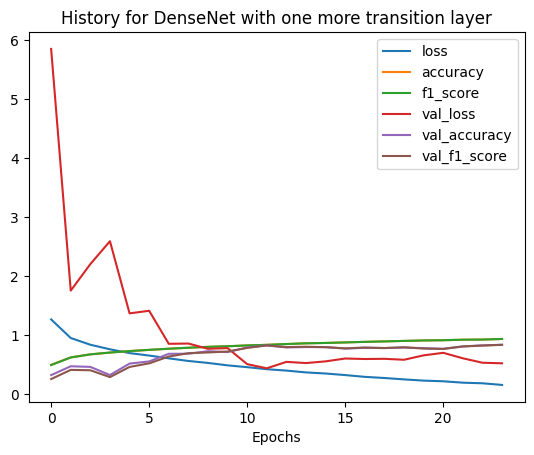

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# Draw the losses over time using plt
losses = pd.DataFrame(history.history).plot();
plt.title("History for DenseNet with one more transition layer")
plt.xlabel("Epochs")
plt.savefig(TFR_PATH+"stage5/last_trans_densenet_losses_over_time.png")
plt.show()